In [2]:
import json
import tensorflow as tf
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [175]:
f = open('Kvasir-SEG/kavsir_bboxes.json')
bboxes = json.load(fp=f)

In [310]:
image_attributes = pd.DataFrame(columns=['image', 'height', 'width', 'n_bboxes', 'bbox'])
for image, attributes in bboxes.items():
    image_attributes.loc[len(image_attributes)] = [image, attributes['height'], attributes['width'], len(attributes['bbox']), attributes['bbox']]

In [311]:
image_attributes

,image,height,width,n_bboxes,bbox
0,cju0qkwl35piu0993l0dewei2,529,622,1,"[{'label': 'polyp', 'xmin': 38, 'ymin': 5, 'xm..."
1,cju0qoxqj9q6s0835b43399p4,1070,1348,1,"[{'label': 'polyp', 'xmin': 194, 'ymin': 284, ..."
2,cju0qx73cjw570799j4n5cjze,529,619,1,"[{'label': 'polyp', 'xmin': 187, 'ymin': 14, '..."
3,cju0roawvklrq0799vmjorwfv,528,622,3,"[{'label': 'polyp', 'xmin': 486, 'ymin': 42, '..."
4,cju0rx1idathl0835detmsp84,528,617,1,"[{'label': 'polyp', 'xmin': 292, 'ymin': 154, ..."
...,...,...,...,...,...
995,cju8b2rmgr52s0801p54eyflx,530,587,1,"[{'label': 'polyp', 'xmin': 172, 'ymin': 114, ..."
996,cju8bj2ssrmlm0871gc2ug2rs,449,469,1,"[{'label': 'polyp', 'xmin': 274, 'ymin': 184, ..."
997,cju8c1a0ws7o208181c6lbsom,546,625,1,"[{'label': 'polyp', 'xmin': 138, 'ymin': 0, 'x..."
998,cju8cgi2kspp308011nxdtjp6,530,619,1,"[{'label': 'polyp', 'xmin': 373, 'ymin': 242, ..."


In [312]:
image_attributes['n_bboxes'].max()

10

(array([945.,  47.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

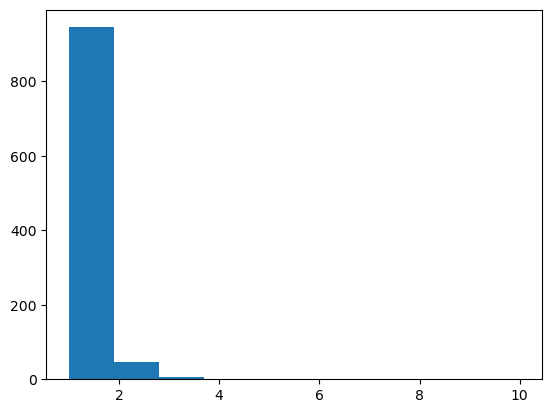

In [313]:
plt.hist(image_attributes['n_bboxes'])

In [314]:
max_bbox_images = image_attributes[image_attributes['n_bboxes'] == image_attributes['n_bboxes'].max()]
max_bbox_images

,image,height,width,n_bboxes,bbox
492,cju3uhb79gcgr0871orbrbi3x,531,622,10,"[{'label': 'polyp', 'xmin': 413, 'ymin': 46, '..."


In [315]:
outlier_image = max_bbox_images.iloc[0]

In [316]:
print(outlier_image['bbox'])

[{'label': 'polyp', 'xmin': 413, 'ymin': 46, 'xmax': 465, 'ymax': 100}, {'label': 'polyp', 'xmin': 100, 'ymin': 70, 'xmax': 164, 'ymax': 126}, {'label': 'polyp', 'xmin': 549, 'ymin': 105, 'xmax': 580, 'ymax': 149}, {'label': 'polyp', 'xmin': 238, 'ymin': 122, 'xmax': 270, 'ymax': 157}, {'label': 'polyp', 'xmin': 373, 'ymin': 140, 'xmax': 428, 'ymax': 186}, {'label': 'polyp', 'xmin': 148, 'ymin': 151, 'xmax': 180, 'ymax': 180}, {'label': 'polyp', 'xmin': 456, 'ymin': 235, 'xmax': 513, 'ymax': 307}, {'label': 'polyp', 'xmin': 234, 'ymin': 265, 'xmax': 270, 'ymax': 302}, {'label': 'polyp', 'xmin': 393, 'ymin': 286, 'xmax': 427, 'ymax': 329}, {'label': 'polyp', 'xmin': 257, 'ymin': 393, 'xmax': 337, 'ymax': 444}]


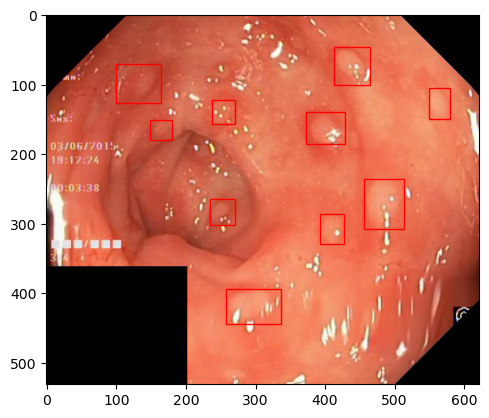

In [317]:
fig, ax = plt.subplots()
ax.imshow(imageio.imread(f'Kvasir-SEG/images/{outlier_image["image"]}.jpg'))
for v in outlier_image['bbox']:
    width = v['xmax'] - v['xmin']
    height = v['ymax'] - v['ymin']
    rect = patches.Rectangle((v['xmin'], v['ymin']), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [1]:
from utils import load_and_pad

In [325]:
image_bboxes = pd.DataFrame(columns=['image', 'n_bboxes', 'x', 'y', 'w', 'h'])
for index, row in image_attributes.iterrows():
    img, pad = load_and_pad(f'Kvasir-SEG/images/{row["image"]}.jpg')
    mask, _ = load_and_pad(f'Kvasir-SEG/masks/{row["image"]}.jpg')
    img = tf.image.resize(img, (256, 256), method='nearest')
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    coeff = 256 / pad
    for v in row['bbox']:
        x = 0.5 * (v['xmin'] + v['xmax']) * coeff
        y = 0.5 * (v['ymin'] + v['ymax']) * coeff
        w = (v['xmax'] - v['xmin']) * coeff
        h = (v['ymax'] - v['ymin']) * coeff
        image_bboxes.loc[len(image_bboxes)] = [row['image'],  row['n_bboxes'], x, y, w, h]
    imageio.imwrite(im=img, uri=f'Kvasir-SEG/preprocessed_images/{row["image"]}.png')
    imageio.imwrite(im=mask, uri=f'Kvasir-SEG/preprocessed_masks/{row["image"]}.png')